In [6]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 35})

In [2]:
# read all of the data
# https://github.com/mttk/STL10
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
def show_images(data,row=1,col=1):
    fig=plt.figure(figsize=(10,10))
    columns = col; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(data[i-1])
    plt.show()

train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [63]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)

def tf_elu(x):   return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer,self.layerA
    
    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        
        return grad_pass,grad,update_w
    
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
class tf_layer_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w * self.c)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
class tf_instance_norm_layer():
    
    def __init__(self,batch_size,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
class tf_box_cox():
    
    def __init__(self):
        self.lmbda    = tf.Variable(2.0) 
        self.m,self.v = tf.Variable(tf.zeros_like(self.lmbda)),tf.Variable(tf.zeros_like(self.lmbda))
    def getw(self): return self.lmbda
    
    def feedforward(self,data):
        self.input = data
        self.layer = tf.pow((self.input + 1.0),self.lmbda)
        return (self.layer - 1.0)/(self.lmbda)
    
    def backprop(self,grad):
        
        # Gradient that gets passed along
        grad_pass = tf.pow((self.input + 1),self.lmbda-1.0) * grad
        
        # Grad respect to the lmbda value (not tested!)
        grad_lmbda1 =   (self.layer * tf.log(self.input + 1 ))/(self.lmbda + 1e-10)
        grad_lmbda2 = - (self.layer - 1)/(self.lmbda ** 2 + 1e-10)
        grad_lmbda  = tf.reduce_mean((grad_lmbda1 + grad_lmbda2)*grad)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad_lmbda)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad_lmbda ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.lmbda,tf.subtract(self.lmbda,adam_middle  )))
        
        return grad_pass,grad_lmbda,update_w
    
def save_to_image(data,name):
    l1g,l2g,l3g,l4g,l5g,l6g = data
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig(name + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')     

In [65]:
# set hyper parameter
num_epoch = 200; learning_rate = 0.001; batch_size = 20; beta1,beta2,adam_e = 0.9,0.999,1e-9

In [7]:
# 1. Normal CNN 
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16); 
l2 = CNN(3,16,16); 
l3 = CNN(3,16,16); 

l4 = CNN(3,16,16); 
l5 = CNN(3,16,16); 
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'Normal/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'Normal/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'Normal/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'Normal/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save('Normal/train.npy',train_acc)
np.save('Normal/test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/200 batch : 7980/8000 acc : 0.25
 Current : 0 Acc : 0.11400000230967998 Test Acc : 0.18837500314228237

Current Iter : 1/200 batch : 7980/8000 acc : 0.35
 Current : 1 Acc : 0.18660000313818453 Test Acc : 0.23000000271946192

Current Iter : 2/200 batch : 7980/8000 acc : 0.25
 Current : 2 Acc : 0.22940000292658805 Test Acc : 0.2683750024437904

Current Iter : 3/200 batch : 7980/8000 acc : 0.35
 Current : 3 Acc : 0.2522000029683113 Test Acc : 0.2903750020917505

Current Iter : 4/200 batch : 7980/8000 acc : 0.35
 Current : 4 Acc : 0.27060000267624856 Test Acc : 0.29937500176019965

Current Iter : 5/200 batch : 7980/8000 acc : 0.45
 Current : 5 Acc : 0.28920000267028806 Test Acc : 0.30387500166893006

Current Iter : 6/200 batch : 7980/8000 acc : 0.45
 Current : 6 Acc : 0.29280000226199626 Test Acc : 0.30712500154040756

Current Iter : 7/200 batch : 7980/8000 acc : 0.35
 Current : 7 Acc : 0.294200002014637 Test Acc : 0.31300000195391475

Current Iter : 8/200 batch : 7980/800

Current Iter : 67/200 batch : 7980/8000 acc : 0.35
 Current : 67 Acc : 0.44940000063180924 Test Acc : 0.3921250002551824

Current Iter : 68/200 batch : 7980/8000 acc : 0.35
 Current : 68 Acc : 0.4482000005841255 Test Acc : 0.39250000049360095

Current Iter : 69/200 batch : 7980/8000 acc : 0.35
 Current : 69 Acc : 0.4492000004649162 Test Acc : 0.39524999985471365

Current Iter : 70/200 batch : 7980/8000 acc : 0.35
 Current : 70 Acc : 0.4514000003933907 Test Acc : 0.3934999998472631

Current Iter : 71/200 batch : 7980/8000 acc : 0.35
 Current : 71 Acc : 0.4526000002026558 Test Acc : 0.39524999996647237

Current Iter : 72/200 batch : 7980/8000 acc : 0.35
 Current : 72 Acc : 0.454000001013279 Test Acc : 0.3931249995343387

Current Iter : 73/200 batch : 7980/8000 acc : 0.35
 Current : 73 Acc : 0.45519999992847443 Test Acc : 0.39549999963492155

Current Iter : 74/200 batch : 7980/8000 acc : 0.35
 Current : 74 Acc : 0.4568000010251999 Test Acc : 0.39574999989941717

Current Iter : 75/200 batc

Current Iter : 134/200 batch : 7980/8000 acc : 0.35
 Current : 134 Acc : 0.5160000013113022 Test Acc : 0.40800000159069894

Current Iter : 135/200 batch : 7980/8000 acc : 0.35
 Current : 135 Acc : 0.5182000017166137 Test Acc : 0.40800000057555735

Current Iter : 136/200 batch : 7980/8000 acc : 0.35
 Current : 136 Acc : 0.517400001168251 Test Acc : 0.4076250012870878

Current Iter : 137/200 batch : 7980/8000 acc : 0.35
 Current : 137 Acc : 0.5198000015020371 Test Acc : 0.40550000097602606

Current Iter : 138/200 batch : 7980/8000 acc : 0.35
 Current : 138 Acc : 0.521400001168251 Test Acc : 0.4073750007897615

Current Iter : 139/200 batch : 7980/8000 acc : 0.35
 Current : 139 Acc : 0.5210000020265579 Test Acc : 0.40812500103376803

Current Iter : 140/200 batch : 7980/8000 acc : 0.35
 Current : 140 Acc : 0.5204000022411347 Test Acc : 0.4090000006556511

Current Iter : 141/200 batch : 7980/8000 acc : 0.35
 Current : 141 Acc : 0.5206000019907951 Test Acc : 0.4088750010356307

Current Iter :

In [8]:
# 2. batch normalization
sess = tf.InteractiveSession()

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_batch_norm_layer(16,(0,1,2))
l2 = CNN(3,16,16); l2n = tf_batch_norm_layer(16,(0,1,2))
l3 = CNN(3,16,16); l3n = tf_batch_norm_layer(16,(0,1,2))
l4 = CNN(3,16,16); l4n = tf_batch_norm_layer(16,(0,1,2))
l5 = CNN(3,16,16); l5n = tf_batch_norm_layer(16,(0,1,2))
l6 = CNN(3,16,10); 

# create the graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)
layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5n = l5n.backprop(grad6p)
grad5p,grad5w,grad5_up = l5.backprop(grad5n)
grad4n = l4n.backprop(grad5p)
grad4p,grad4w,grad4_up = l4.backprop(grad4n,stride=2)

grad3n = l3n.backprop(grad4p)
grad3p,grad3w,grad3_up = l3.backprop(grad3n,stride=2)
grad2n = l2n.backprop(grad3p)
grad2p,grad2w,grad2_up = l2.backprop(grad2n,stride=2)
grad1n = l1n.backprop(grad2p)
grad1p,grad1w,grad1_up = l1.backprop(grad1n,stride=2)

update_ops  = update1 + update2 + update3 + update4 + update5
gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = []; test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'batch Norm/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'batch Norm/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'batch Norm/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'batch Norm/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
   
np.save('batch Norm/train.npy',train_acc)
np.save('batch Norm/test.npy', test_acc)
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/200 batch : 7980/8000 acc : 0.35
 Current : 0 Acc : 0.2766000022739172 Test Acc : 0.296625001989305

Current Iter : 1/200 batch : 7980/8000 acc : 0.35
 Current : 1 Acc : 0.35040000222623346 Test Acc : 0.36412500159814953

Current Iter : 2/200 batch : 7980/8000 acc : 0.45
 Current : 2 Acc : 0.386200001552701 Test Acc : 0.38925000132061544

Current Iter : 3/200 batch : 7980/8000 acc : 0.55
 Current : 3 Acc : 0.4256000012159348 Test Acc : 0.4056250012293458

Current Iter : 4/200 batch : 7980/8000 acc : 0.55
 Current : 4 Acc : 0.4468000010251999 Test Acc : 0.401250001527369

Current Iter : 5/200 batch : 7980/8000 acc : 0.45
 Current : 5 Acc : 0.4640000008046627 Test Acc : 0.42287500207312406

Current Iter : 6/200 batch : 7980/8000 acc : 0.55
 Current : 6 Acc : 0.4894000007510185 Test Acc : 0.4295000021252781

Current Iter : 7/200 batch : 7980/8000 acc : 0.55
 Current : 7 Acc : 0.5056000011563301 Test Acc : 0.4326250012777746

Current Iter : 8/200 batch : 7980/8000 acc : 0.

Current Iter : 68/200 batch : 7980/8000 acc : 0.45
 Current : 68 Acc : 0.867599999666214 Test Acc : 0.4348750016186386

Current Iter : 69/200 batch : 7980/8000 acc : 0.45
 Current : 69 Acc : 0.8715999991893768 Test Acc : 0.4385000020079315

Current Iter : 70/200 batch : 7980/8000 acc : 0.45
 Current : 70 Acc : 0.8749999983310699 Test Acc : 0.4386250011064112

Current Iter : 71/200 batch : 7980/8000 acc : 0.45
 Current : 71 Acc : 0.8789999995231629 Test Acc : 0.4378750023804605

Current Iter : 72/200 batch : 7980/8000 acc : 0.45
 Current : 72 Acc : 0.8789999976158142 Test Acc : 0.4415000015310943

Current Iter : 73/200 batch : 7980/8000 acc : 0.35
 Current : 73 Acc : 0.8839999980926514 Test Acc : 0.43925000162795186

Current Iter : 74/200 batch : 7980/8000 acc : 0.35
 Current : 74 Acc : 0.8843999993801117 Test Acc : 0.439625001642853

Current Iter : 75/200 batch : 7980/8000 acc : 0.45
 Current : 75 Acc : 0.8855999977588653 Test Acc : 0.4322500024549663

Current Iter : 76/200 batch : 798

Current Iter : 135/200 batch : 7980/8000 acc : 0.45
 Current : 135 Acc : 0.9767999951839447 Test Acc : 0.42462500136345627

Current Iter : 136/200 batch : 7980/8000 acc : 0.35
 Current : 136 Acc : 0.9763999950885772 Test Acc : 0.42025000242516397

Current Iter : 137/200 batch : 7980/8000 acc : 0.35
 Current : 137 Acc : 0.975599995136261 Test Acc : 0.42750000167638064

Current Iter : 138/200 batch : 7980/8000 acc : 0.45
 Current : 138 Acc : 0.9785999956130982 Test Acc : 0.423875002078712

Current Iter : 139/200 batch : 7980/8000 acc : 0.35
 Current : 139 Acc : 0.9821999959945679 Test Acc : 0.42925000093877314

Current Iter : 140/200 batch : 7980/8000 acc : 0.45
 Current : 140 Acc : 0.9791999957561492 Test Acc : 0.43075000174343586

Current Iter : 141/200 batch : 7980/8000 acc : 0.35
 Current : 141 Acc : 0.977199994802475 Test Acc : 0.41850000189617276

Current Iter : 142/200 batch : 7980/8000 acc : 0.45
 Current : 142 Acc : 0.9791999950408935 Test Acc : 0.41737500209361317

Current Iter

In [9]:
# 3. layer normalization
sess = tf.InteractiveSession()

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_layer_norm_layer(batch_size,(1,2,3))
l2 = CNN(3,16,16); l2n = tf_layer_norm_layer(batch_size,(1,2,3))
l3 = CNN(3,16,16); l3n = tf_layer_norm_layer(batch_size,(1,2,3))
l4 = CNN(3,16,16); l4n = tf_layer_norm_layer(batch_size,(1,2,3))
l5 = CNN(3,16,16); l5n = tf_layer_norm_layer(batch_size,(1,2,3))
l6 = CNN(3,16,10); 

# create the graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)
layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5n = l5n.backprop(grad6p)
grad5p,grad5w,grad5_up = l5.backprop(grad5n)
grad4n = l4n.backprop(grad5p)
grad4p,grad4w,grad4_up = l4.backprop(grad4n,stride=2)

grad3n = l3n.backprop(grad4p)
grad3p,grad3w,grad3_up = l3.backprop(grad3n,stride=2)
grad2n = l2n.backprop(grad3p)
grad2p,grad2w,grad2_up = l2.backprop(grad2n,stride=2)
grad1n = l1n.backprop(grad2p)
grad1p,grad1w,grad1_up = l1.backprop(grad1n,stride=2)

update_ops  = update1 + update2 + update3 + update4 + update5
gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = []; test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'Layer Norm/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'Layer Norm/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'Layer Norm/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'Layer Norm/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
   
np.save('Layer Norm/train.npy',train_acc)
np.save('Layer Norm/test.npy', test_acc)
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/200 batch : 7980/8000 acc : 0.25
 Current : 0 Acc : 0.19500000247359275 Test Acc : 0.22662500338628888

Current Iter : 1/200 batch : 7980/8000 acc : 0.35
 Current : 1 Acc : 0.30560000240802765 Test Acc : 0.30075000238604843

Current Iter : 2/200 batch : 7980/8000 acc : 0.45
 Current : 2 Acc : 0.35300000140070914 Test Acc : 0.32475000170059504

Current Iter : 3/200 batch : 7980/8000 acc : 0.45
 Current : 3 Acc : 0.3826000009179115 Test Acc : 0.33487500187940894

Current Iter : 4/200 batch : 7980/8000 acc : 0.45
 Current : 4 Acc : 0.404600001424551 Test Acc : 0.34162500167265536

Current Iter : 5/200 batch : 7980/8000 acc : 0.55
 Current : 5 Acc : 0.42480000150203706 Test Acc : 0.35112500144168735

Current Iter : 6/200 batch : 7980/8000 acc : 0.55
 Current : 6 Acc : 0.44020000159740447 Test Acc : 0.35375000115484

Current Iter : 7/200 batch : 7980/8000 acc : 0.55
 Current : 7 Acc : 0.45660000091791153 Test Acc : 0.35350000121630726

Current Iter : 8/200 batch : 7980/8000

Current Iter : 68/200 batch : 7980/8000 acc : 0.55
 Current : 68 Acc : 0.7776000006198883 Test Acc : 0.34287500185891984

Current Iter : 69/200 batch : 7980/8000 acc : 0.55
 Current : 69 Acc : 0.7796000008583068 Test Acc : 0.34362500183284284

Current Iter : 70/200 batch : 7980/8000 acc : 0.55
 Current : 70 Acc : 0.7832000007629395 Test Acc : 0.34175000185146925

Current Iter : 71/200 batch : 7980/8000 acc : 0.55
 Current : 71 Acc : 0.7860000011920929 Test Acc : 0.34487500159069895

Current Iter : 72/200 batch : 7980/8000 acc : 0.55
 Current : 72 Acc : 0.7876000009775161 Test Acc : 0.3415000017918646

Current Iter : 73/200 batch : 7980/8000 acc : 0.55
 Current : 73 Acc : 0.7920000004768372 Test Acc : 0.3422500019147992

Current Iter : 74/200 batch : 7980/8000 acc : 0.55
 Current : 74 Acc : 0.7900000003576279 Test Acc : 0.343375002136454

Current Iter : 75/200 batch : 7980/8000 acc : 0.55
 Current : 75 Acc : 0.7968000019788742 Test Acc : 0.3448750018235296

Current Iter : 76/200 batch :

Current Iter : 135/200 batch : 7980/8000 acc : 0.35
 Current : 135 Acc : 0.941799993276596 Test Acc : 0.3395000017620623

Current Iter : 136/200 batch : 7980/8000 acc : 0.35
 Current : 136 Acc : 0.940999993801117 Test Acc : 0.3408750015310943

Current Iter : 137/200 batch : 7980/8000 acc : 0.35
 Current : 137 Acc : 0.9373999931812287 Test Acc : 0.3386250015068799

Current Iter : 138/200 batch : 7980/8000 acc : 0.35
 Current : 138 Acc : 0.9409999928474426 Test Acc : 0.34175000175833703

Current Iter : 139/200 batch : 7980/8000 acc : 0.35
 Current : 139 Acc : 0.9443999941349029 Test Acc : 0.34362500230781734

Current Iter : 140/200 batch : 7980/8000 acc : 0.35
 Current : 140 Acc : 0.950199993133545 Test Acc : 0.34587500215508044

Current Iter : 141/200 batch : 7980/8000 acc : 0.35
 Current : 141 Acc : 0.9557999942302704 Test Acc : 0.3477500014193356

Current Iter : 142/200 batch : 7980/8000 acc : 0.35
 Current : 142 Acc : 0.9547999930381775 Test Acc : 0.3507500014360994

Current Iter : 1

In [10]:
# 4. Instance normalization
sess = tf.InteractiveSession()

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_instance_norm_layer(batch_size,16,(1,2))
l2 = CNN(3,16,16); l2n = tf_instance_norm_layer(batch_size,16,(1,2))
l3 = CNN(3,16,16); l3n = tf_instance_norm_layer(batch_size,16,(1,2))
l4 = CNN(3,16,16); l4n = tf_instance_norm_layer(batch_size,16,(1,2))
l5 = CNN(3,16,16); l5n = tf_instance_norm_layer(batch_size,16,(1,2))
l6 = CNN(3,16,10); 

# create the graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)
layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5n = l5n.backprop(grad6p)
grad5p,grad5w,grad5_up = l5.backprop(grad5n)
grad4n = l4n.backprop(grad5p)
grad4p,grad4w,grad4_up = l4.backprop(grad4n,stride=2)

grad3n = l3n.backprop(grad4p)
grad3p,grad3w,grad3_up = l3.backprop(grad3n,stride=2)
grad2n = l2n.backprop(grad3p)
grad2p,grad2w,grad2_up = l2.backprop(grad2n,stride=2)
grad1n = l1n.backprop(grad2p)
grad1p,grad1w,grad1_up = l1.backprop(grad1n,stride=2)

update_ops  = update1 + update2 + update3 + update4 + update5
gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = []; test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'Instace Norm/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'Instace Norm/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'Instace Norm/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'Instace Norm/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
   
np.save('Instace Norm/train.npy',train_acc)
np.save('Instace Norm/test.npy', test_acc)
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/200 batch : 7980/8000 acc : 0.15
 Current : 0 Acc : 0.22260000279545783 Test Acc : 0.21975000274367631

Current Iter : 1/200 batch : 7980/8000 acc : 0.25
 Current : 1 Acc : 0.31740000219643116 Test Acc : 0.20975000359117985

Current Iter : 2/200 batch : 7980/8000 acc : 0.25
 Current : 2 Acc : 0.35960000155866145 Test Acc : 0.2136250035278499

Current Iter : 3/200 batch : 7980/8000 acc : 0.15
 Current : 3 Acc : 0.39680000112950803 Test Acc : 0.19737500299699604

Current Iter : 4/200 batch : 7980/8000 acc : 0.15
 Current : 4 Acc : 0.42100000075995925 Test Acc : 0.20587500284425914

Current Iter : 5/200 batch : 7980/8000 acc : 0.25
 Current : 5 Acc : 0.4434000019580126 Test Acc : 0.1856250030826777

Current Iter : 6/200 batch : 7980/8000 acc : 0.15
 Current : 6 Acc : 0.4574000013619661 Test Acc : 0.19950000279583036

Current Iter : 7/200 batch : 7980/8000 acc : 0.25
 Current : 7 Acc : 0.47240000143647193 Test Acc : 0.19662500304169953

Current Iter : 8/200 batch : 7980/80

Current Iter : 68/200 batch : 7980/8000 acc : 0.15
 Current : 68 Acc : 0.8298000028133392 Test Acc : 0.15075000294484198

Current Iter : 69/200 batch : 7980/8000 acc : 0.15
 Current : 69 Acc : 0.828600002527237 Test Acc : 0.15450000327080488

Current Iter : 70/200 batch : 7980/8000 acc : 0.15
 Current : 70 Acc : 0.8310000021457672 Test Acc : 0.15237500291317702

Current Iter : 71/200 batch : 7980/8000 acc : 0.15
 Current : 71 Acc : 0.835400002002716 Test Acc : 0.1523750030528754

Current Iter : 72/200 batch : 7980/8000 acc : 0.15
 Current : 72 Acc : 0.8396000030040741 Test Acc : 0.15325000300072134

Current Iter : 73/200 batch : 7980/8000 acc : 0.15
 Current : 73 Acc : 0.842800000667572 Test Acc : 0.1546250030398369

Current Iter : 74/200 batch : 7980/8000 acc : 0.15
 Current : 74 Acc : 0.8456000018119813 Test Acc : 0.14925000303424896

Current Iter : 75/200 batch : 7980/8000 acc : 0.15
 Current : 75 Acc : 0.8474000008106232 Test Acc : 0.15112500317394734

Current Iter : 76/200 batch :

Current Iter : 135/200 batch : 7980/8000 acc : 0.15
 Current : 135 Acc : 0.9503999927043915 Test Acc : 0.12637500263750553

Current Iter : 136/200 batch : 7980/8000 acc : 0.15
 Current : 136 Acc : 0.952399992465973 Test Acc : 0.12825000271201134

Current Iter : 137/200 batch : 7980/8000 acc : 0.15
 Current : 137 Acc : 0.9493999917507172 Test Acc : 0.12975000259466468

Current Iter : 138/200 batch : 7980/8000 acc : 0.15
 Current : 138 Acc : 0.9549999921321869 Test Acc : 0.13237500259652735

Current Iter : 139/200 batch : 7980/8000 acc : 0.25
 Current : 139 Acc : 0.955999992609024 Test Acc : 0.13400000284425914

Current Iter : 140/200 batch : 7980/8000 acc : 0.15
 Current : 140 Acc : 0.9601999926567077 Test Acc : 0.13537500280886888

Current Iter : 141/200 batch : 7980/8000 acc : 0.15
 Current : 141 Acc : 0.9627999925613403 Test Acc : 0.13012500274926425

Current Iter : 142/200 batch : 7980/8000 acc : 0.15
 Current : 142 Acc : 0.9659999938011169 Test Acc : 0.13050000277347862

Current It

In [ ]:
# 5. box cox 
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16); l1n = tf_box_cox()
l2 = CNN(3,16,16); l2n = tf_box_cox()
l3 = CNN(3,16,16); l3n = tf_box_cox()

l4 = CNN(3,16,16); l4n = tf_box_cox()
l5 = CNN(3,16,16); l5n = tf_box_cox()
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer1a = l1n.feedforward(layer1a)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer2a = l2n.feedforward(layer2a)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer3a = l3n.feedforward(layer3a)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer4a = l4n.feedforward(layer4a)
layer5, layer5a = l5. feedforward(layer4a)
layer5a = l5n.feedforward(layer5a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up  = l6.backprop(gradient)
grad5n,grad5l,grad5n_up = l5n.backprop(grad6p)
grad5p,grad5w,grad5_up  = l5.backprop(grad5n)
grad4n,grad4l,grad4n_up = l4n.backprop(grad5p)
grad4p,grad4w,grad4_up  = l4.backprop(grad4n,stride=2)

grad3n,grad3l,grad3n_up = l3n.backprop(grad4p)
grad3p,grad3w,grad3_up  = l3.backprop(grad3n,stride=2)
grad2n,grad2l,grad2n_up = l2n.backprop(grad3p)
grad2p,grad2w,grad2_up  = l2.backprop(grad2n,stride=2)
grad1n,grad1l,grad1n_up = l1n.backprop(grad2p)
grad1p,grad1w,grad1_up  = l1.backprop(grad1n,stride=2)

gradient_update = grad6_up + grad5n_up + grad5_up + grad4n_up +  grad4_up + grad3n_up + grad3_up + grad2n_up + grad2_up + grad1n_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
#     save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'Box Cox/weights/')
#     save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'Box Cox/gradientw/')
#     save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'Box Cox/gradientp/')
#     save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'Box Cox/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save('Box Cox/train.npy',train_acc)
np.save('Box Cox/test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/200 batch : 7980/8000 acc : 0.15
 Current : 0 Acc : 0.11260000216960907 Test Acc : 0.10187500207684934

Current Iter : 1/200 batch : 7980/8000 acc : 0.35
 Current : 1 Acc : 0.15920000271499157 Test Acc : 0.19550000313669444

Current Iter : 2/200 batch : 7980/8000 acc : 0.35
 Current : 2 Acc : 0.20820000286400317 Test Acc : 0.2372500030323863

Current Iter : 3/200 batch : 7980/8000 acc : 0.35
 Current : 3 Acc : 0.22980000348389149 Test Acc : 0.2656250026635826

Current Iter : 4/200 batch : 7980/8000 acc : 0.35
 Current : 4 Acc : 0.24940000323951245 Test Acc : 0.2676250028703362

Current Iter : 5/200 batch : 7980/8000 acc : 0.35
 Current : 5 Acc : 0.2788000022917986 Test Acc : 0.2713750026095659

Current Iter : 6/200 batch : 7980/8000 acc : 0.45
 Current : 6 Acc : 0.28620000219345093 Test Acc : 0.28762500209733843

Current Iter : 7/200 batch : 7980/8000 acc : 0.45
 Current : 7 Acc : 0.29880000223219394 Test Acc : 0.29237500262446703

Current Iter : 8/200 batch : 7980/800

Current Iter : 67/200 batch : 7980/8000 acc : 0.35
 Current : 67 Acc : 0.4792000015974045 Test Acc : 0.3825000016111881

Current Iter : 68/200 batch : 7980/8000 acc : 0.45
 Current : 68 Acc : 0.4768000017404556 Test Acc : 0.39050000147894026

Current Iter : 69/200 batch : 7980/8000 acc : 0.45
 Current : 69 Acc : 0.48120000129938123 Test Acc : 0.38600000138394536

Current Iter : 70/200 batch : 7980/8000 acc : 0.45
 Current : 70 Acc : 0.4816000021696091 Test Acc : 0.3832500019017607

Current Iter : 71/200 batch : 7980/8000 acc : 0.35
 Current : 71 Acc : 0.48580000168085097 Test Acc : 0.38725000199861825

Current Iter : 72/200 batch : 7980/8000 acc : 0.45
 Current : 72 Acc : 0.49240000218153 Test Acc : 0.3861250013206154

Current Iter : 73/200 batch : 7980/8000 acc : 0.45
 Current : 73 Acc : 0.4986000013947487 Test Acc : 0.39200000185519457

Current Iter : 74/200 batch : 7980/8000 acc : 0.45
 Current : 74 Acc : 0.5010000023245812 Test Acc : 0.39437500192783775

Current Iter : 75/200 batch

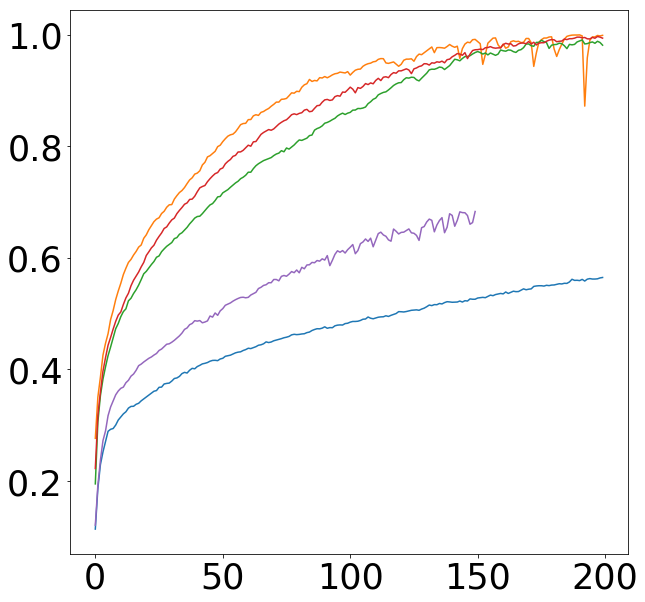

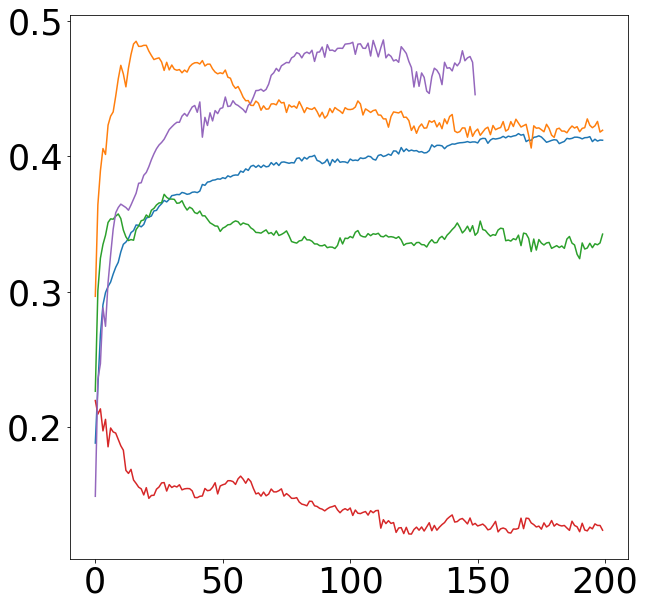

In [55]:
# read and plot all accuracy
normal = np.load('Normal/train.npy')
batch  = np.load("batch Norm/train.npy")
layer  = np.load("Layer Norm/train.npy")
instace= np.load("Instace Norm/train.npy")
boxcox = np.load("Box Cox/train.npy")

plt.figure(figsize=(10,10))
plt.plot(normal); plt.plot(batch); plt.plot(layer); plt.plot(instace); plt.plot(boxcox); 
plt.show()

normal = np.load('Normal/test.npy')
batch  = np.load("batch Norm/test.npy")
layer  = np.load("Layer Norm/test.npy")
instace= np.load("Instace Norm/test.npy")
boxcox = np.load("Box Cox/test.npy")

plt.figure(figsize=(10,10))
plt.plot(normal); plt.plot(batch); plt.plot(layer); plt.plot(instace); plt.plot(boxcox); 
plt.show()

In [ ]:
%%notify
print('done')

# Reference
1. mttk/STL10. (2018). GitHub. Retrieved 19 December 2018, from https://github.com/mttk/STL10
2. [duplicate], H. (2018). How to display multiple images in one figure correctly?. Stack Overflow. Retrieved 19 December 2018, from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
3. plot, H. (2010). How to change the font size on a matplotlib plot. Stack Overflow. Retrieved 20 December 2018, from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
4. ShopRunner/jupyter-notify. (2018). GitHub. Retrieved 20 December 2018, from https://github.com/ShopRunner/jupyter-notify